In [2]:
import rioxarray

In [6]:
cog_url = (
    "https://s3.us-east-2.amazonaws.com/vtopendata-prd/Elevation/2017_70cm_DEMHF.tif"
    )
rds = rioxarray.open_rasterio(cog_url, overview_level=2)

In [7]:
rds.squeeze()

<xarray.DataArray (y: 45500, x: 15000)> Size: 3GB
[682500000 values with dtype=float32]
Coordinates:
    band         int64 8B 1
  * x            (x) float64 120kB 4.256e+05 4.256e+05 ... 5.096e+05 5.096e+05
  * y            (y) float64 364kB 2.8e+05 2.8e+05 ... 2.521e+04 2.52e+04
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -9999.0
    scale_factor:   1.0
    add_offset:     0.0

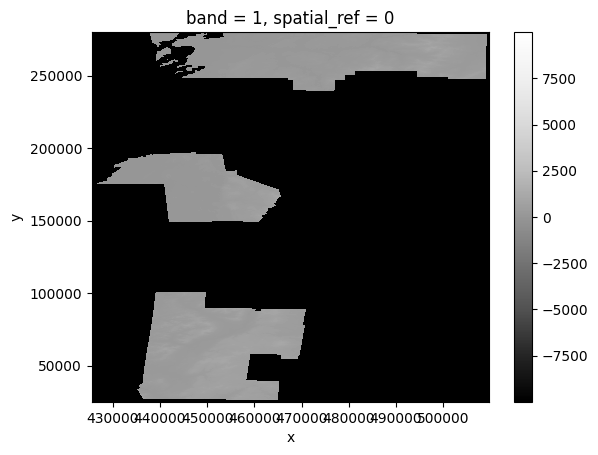

In [8]:
rds.squeeze().plot.imshow(cmap="Greys_r")